In [2]:
# This code interpolates temperature, calculates heat wave indices in a grid, plot hotspots and trends
# Author: Marlon Passos

In [147]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF, Matern
# Interpolate spatially using GaussianProcessRegressor (modified Kriging)
# create a grid of latitude and longitude coordinates
lat_grid = np.linspace(df_stations['latitude'].min(), df_stations['latitude'].max()+0.5, 100) # corrected
lon_grid = np.linspace(df_stations['longitude'].min(), df_stations['longitude'].max(), 100)
nx = len(lon_grid)
ny = len(lat_grid)

# group temperature data by time
temp_groups = df_all.groupby('ref')
datesout=[]
dataout=np.zeros((len(temp_groups),ny,nx))
out_rsquared=[]
in_rsquared=[]
# loop over groups and perform Kriging interpolation for each group
t=0
for time, temp_subset in temp_groups:
    datesout.append(time.to_pydatetime())
    temp_subset = temp_subset[['station_id', 'value', 'ref']]
    # merge df_stations and temp_subset on the station name
    merged_df = pd.merge(df_stations[['id', 'latitude', 'longitude']], temp_subset, left_on='id', right_on='station_id')
    # Split data into testing and training sets
    merged_train=merged_df[['latitude','longitude']]
    coords_train, coords_test, value_train, value_test = train_test_split(merged_train, merged_df['value'], test_size = 0.20, random_state = 42)
    coords_train_wgs = [np.array(xy) for xy in zip(coords_train.longitude.values, coords_train.latitude.values)]
    coords_test_wgs = [np.array(xy) for xy in zip(coords_test.longitude.values, coords_test.latitude.values)]
    XX_sk_krig, YY_sk_krig = np.mgrid[lon_grid.min():lon_grid.max():100j, lat_grid.min():lat_grid.max():100j]
    # Create 2-D array of the coordinates (paired) of each cell in the mesh grid
    positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

    # Generate Gaussian Process model (can change parameters as desired)
    kernel=Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1000.0)) # better out of sample interpolation
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1,
                                          normalize_y=True,
                                          n_restarts_optimizer=10)

    # Fit kernel density estimator to coordinates and values
    gp.fit(coords_train_wgs, value_train)

    # Evaluate the model on coordinate pairs
    Z_sk_krig = gp.predict(positions_sk_krig)

    # Reshape the data to fit mesh grid
    interp_temps = Z_sk_krig.reshape(XX_sk_krig.shape)
    # Generate in-sample R^2
    in_r_squared_sk_krig = gp.score(coords_train_wgs, value_train)
    print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))
    in_rsquared.append(in_r_squared_sk_krig)
    # Generate out-of-sample R^2
    out_r_squared_sk_krig = gp.score(coords_test_wgs, value_test)
    print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))
    out_rsquared.append(out_r_squared_sk_krig)
    # Check for stable results
    if np.nanmax(interp_temps)<upper_limit and np.nanmin(interp_temps)>lower_limit:
        dataout[t,:]=interp_temps
    else:
        dataout[t,:]=np.nan
        print('error')
        debug_temps=interp_temps
        debug_df=merged_df
        break
    print(time)
    t=t+1
print(np.mean(in_rsquared))
print(np.mean(out_rsquared))


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1922-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1922-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1922-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1922-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.59
1922-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -2.78
1922-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1922-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1922-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -1.58
1922-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -2.34
1922-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1922-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.48
1922-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -2.75
1922-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -2.25
1922-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1922-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1922-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Sciki

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.52
1922-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.36
1922-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.87
1922-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -18.05
1922-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -4.9
1922-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -2.95
1922-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.29
1922-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -3.58
1922-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
S

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.5
1922-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.6
1922-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.95
1922-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.6
1922-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1922-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.25
1922-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1922-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1922-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1922-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1922-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1922-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.82
1922-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.98
1922-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.52
1922-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.49
1922-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: -21.81
1922-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Sc

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -7.34
1922-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.08
1922-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -2.17
1922-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1922-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1922-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1922-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.31
1922-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -1.56
1922-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scik

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1922-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1922-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1922-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1922-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1922-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1922-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1922-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.99
1922-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.1
1923-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1923-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.76
1923-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1923-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1923-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1923-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1923-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1923-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -3.9
1923-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.43
1923-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -5.58
1923-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1923-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -6.86
1923-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -5.96
1923-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.15
1923-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -3.66
1923-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Sci

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1923-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.52
1923-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1923-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1923-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.9
1923-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1923-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1923-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -5.83
1923-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.66
1923-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1923-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -22.1
1923-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -2.06
1923-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1923-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1923-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1923-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.19
1923-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scik

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1923-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.41
1923-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1923-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1923-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1923-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1923-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1923-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1923-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1923-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1924-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1924-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1924-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1924-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1924-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1924-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.09
1924-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.05
1924-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1924-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1924-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1924-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1924-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1924-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1924-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1924-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.37
1924-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.29
1924-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1924-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1924-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.11
1924-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1924-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1924-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1924-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.74
1924-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1924-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1924-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1924-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1924-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1924-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1924-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1924-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Sciki

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.76
1924-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1924-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1924-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.14
1924-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1924-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1924-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1924-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1924-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1924-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1924-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1924-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1924-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1924-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1924-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1924-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1924-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1924-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1924-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1924-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1924-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1924-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1924-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1924-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1924-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1925-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1925-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1925-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.54
1925-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1925-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1925-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1925-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1925-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1925-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.3
1925-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1925-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1925-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1925-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1925-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1925-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.23
1925-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scik

1925-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1925-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: -0.15
1925-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -2.57
1925-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.6
1925-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1925-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1925-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.09
1925-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.23
1925-07-14 00:00:00
Scikit-Learn Kriging in-sample r

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1925-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1925-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1925-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1925-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.94
1925-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1925-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -1.07
1925-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.3
1925-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1925-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1925-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1925-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1925-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.26
1925-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.36
1925-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1925-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.82
1925-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.99
1926-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1926-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1926-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1926-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1926-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.73
1926-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1926-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.81
1926-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.35
1926-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.9
1926-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.11
1926-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.65
1926-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1926-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.35
1926-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -5.83
1926-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.58
1926-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Sci

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1926-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.23
1926-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.68
1926-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.93
1926-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -2.03
1926-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1926-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1926-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -3.25
1926-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Sci

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.73
1926-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1926-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -1.9
1926-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -2.21
1926-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.71
1926-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1926-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1926-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1926-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1926-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1926-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1926-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1926-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1926-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1926-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1926-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1926-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1927-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1927-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.19
1927-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.68
1927-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.3
1927-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1927-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1927-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1927-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1927-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.46
1927-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.43
1927-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.56
1927-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1927-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1927-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.35
1927-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: -1.4
1927-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scik

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1927-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1927-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1927-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.48
1927-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -10.49
1927-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.55
1927-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1927-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.23
1927-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Sci

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -10.0
1927-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1927-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -9.57
1927-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.49
1927-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -10.4
1927-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -2.38
1927-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.69
1927-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1927-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scik

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1927-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1927-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1927-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.37
1927-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -2.94
1927-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1927-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1927-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1927-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -1.41
1928-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1928-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1928-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -1.73
1928-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1928-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1928-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1928-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1928-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1928-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.61
1928-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.58
1928-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1928-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1928-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1928-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1928-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1928-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Sciki

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -1.49
1928-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.68
1928-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.11
1928-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1928-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1928-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1928-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1928-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1928-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.73
1928-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1928-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1928-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.28
1928-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1928-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.88
1928-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1928-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1928-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scik

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1928-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.37
1928-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.79
1928-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -4.0
1928-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1928-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1928-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.57
1928-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1928-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Sciki

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1928-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1928-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1928-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1928-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1928-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1928-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1928-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1928-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1929-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1929-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1929-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.1
1929-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1929-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -1.49
1929-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1929-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1929-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1929-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1929-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.15
1929-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.38
1929-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1929-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1929-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1929-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1929-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1929-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1929-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.58
1929-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.7
1929-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.36
1929-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1929-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1929-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1929-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1929-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1929-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1929-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -24.44
1929-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1929-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.38
1929-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1929-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -2.42
1929-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Sciki

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1929-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1929-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1929-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1929-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1929-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1929-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -3.36
1929-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1929-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1930-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1930-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1930-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1930-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1930-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1930-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1930-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1930-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1930-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1930-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1930-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1930-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1930-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.34
1930-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -6.06
1930-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.11
1930-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.61
1930-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1930-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.31
1930-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1930-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1930-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.65
1930-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.0
1930-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.12
1930-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Sciki

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1930-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1930-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1930-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1930-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1930-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1930-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1930-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1930-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: -0.58
1930-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.71
1930-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1930-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1930-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1930-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1930-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1930-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1930-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1930-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1930-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1930-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1930-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1930-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1930-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1930-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1930-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1931-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1931-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1931-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1931-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1931-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1931-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1931-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1931-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1931-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1931-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.41
1931-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.53
1931-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.7
1931-03-21 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1931-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1931-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1931-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1931-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1931-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1931-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1931-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1931-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.55
1931-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.39
1931-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1931-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1931-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.24
1931-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.0
1931-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.46
1931-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: -0.15
1931-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Sci

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1931-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -2.63
1931-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -4.01
1931-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1931-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.09
1931-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1931-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1931-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1931-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1931-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1931-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.68
1931-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1931-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1931-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1931-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.54
1931-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.82
1931-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scik

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1931-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1931-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.23
1931-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1931-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1931-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1931-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1931-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1931-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.84
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1931-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1931-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1931-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1931-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1931-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1931-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1931-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1931-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1932-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1932-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1932-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1932-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1932-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1932-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1932-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1932-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1932-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1932-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1932-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1932-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1932-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1932-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.11
1932-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1932-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1932-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1932-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.26
1932-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1932-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1932-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.45
1932-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.56
1932-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1932-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1932-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1932-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1932-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1932-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1932-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1932-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1932-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1932-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1932-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1932-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1932-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1932-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1932-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1932-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1932-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1932-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.49
1933-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.36
1933-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1933-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1933-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1933-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1933-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1933-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1933-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1933-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1933-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1933-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.36
1933-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1933-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1933-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1933-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1933-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.45
1933-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.26
1933-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.18
1933-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1933-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1933-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1933-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1933-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1933-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scik

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1933-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1933-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1933-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1933-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1933-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1933-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1933-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1933-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1933-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1933-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1933-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1933-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1933-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1933-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1933-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1933-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1934-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1934-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1934-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.33
1934-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1934-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1934-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1934-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1934-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.64
1934-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -1.12
1934-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.79
1934-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.31
1934-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1934-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1934-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1934-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1934-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.78
1934-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1934-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1934-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1934-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1934-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1934-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1934-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.49
1934-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Sciki

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1934-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1934-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.44
1934-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -2.19
1934-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.94
1934-06-29 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1934-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1934-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1934-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1934-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1934-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1934-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1934-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.09
1934-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1934-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1934-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1934-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1934-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1934-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.57
1934-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.08
1934-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.55
1934-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1934-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1934-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.44
1934-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1934-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1934-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1934-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1934-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.09
1934-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Sciki

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1934-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1934-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1934-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1934-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1934-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1934-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1934-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1934-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1935-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1935-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1935-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1935-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1935-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.08
1935-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1935-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1935-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1935-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.52
1935-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1935-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1935-04-19 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1935-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: -0.54
1935-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1935-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1935-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.94
1935-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1935-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1935-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1935-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1935-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1935-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1935-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -2.44
1935-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1935-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1935-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1935-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1935-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.21
1935-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.43
1935-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1935-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1935-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.31
1935-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1935-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1935-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1935-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Sci

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1935-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1935-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1935-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1935-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1935-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1935-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1935-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1935-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.41
1935-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -1.03
1935-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -6.69
1935-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -19.84
1935-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1935-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1935-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1935-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1935-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scik

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1936-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1936-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1936-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1936-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1936-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1936-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1936-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1936-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1936-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.2
1936-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1936-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1936-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1936-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1936-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1936-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1936-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -1.28
1936-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1936-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.26
1936-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1936-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1936-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1936-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1936-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1936-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1936-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1936-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.43
1936-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1936-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1936-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1936-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1936-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1936-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1936-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1936-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1936-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1936-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1936-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1936-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1936-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1936-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1936-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1936-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1936-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1936-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1936-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1936-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1936-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1936-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1937-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1937-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1937-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1937-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1937-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1937-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1937-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1937-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1937-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.1
1937-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.15
1937-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1937-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: -0.52
1937-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1937-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1937-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1937-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1937-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1937-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1937-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1937-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.08
1937-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1937-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1937-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1937-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1937-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1937-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1937-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1937-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1937-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.33
1937-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1937-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1937-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1937-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1937-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1937-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.11
1937-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1937-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.08
1937-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1937-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1937-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1937-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1937-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1937-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1937-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1937-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1937-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1937-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1937-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1937-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1937-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1937-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1937-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1937-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1937-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1937-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1937-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1938-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1938-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1938-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1938-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1938-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1938-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.11
1938-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.68
1938-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1938-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1938-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1938-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.54
1938-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1938-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1938-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1938-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1938-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1938-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1938-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1938-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1938-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1938-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1938-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.22
1938-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1938-07-11 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1938-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -3.87
1938-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.37
1938-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1938-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.37
1938-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.25
1938-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1938-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1938-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Sciki

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1938-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.43
1938-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.09
1938-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1938-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1938-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.35
1938-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.55
1938-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.65
1938-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Sc

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1938-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1938-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1938-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1938-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1938-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1938-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1938-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1938-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1939-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1939-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1939-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1939-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.44
1939-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1939-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.18
1939-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1939-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.09
1939-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1939-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1939-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1939-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1939-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1939-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1939-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1939-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1939-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1939-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1939-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1939-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1939-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1939-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1939-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1939-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1939-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1939-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1939-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1939-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1939-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1939-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1939-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1939-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1939-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1939-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1939-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1939-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1939-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1939-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1939-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1939-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1939-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1939-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1939-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1939-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1939-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1939-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1939-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1939-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1939-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1939-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1939-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1939-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1939-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1939-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1939-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1939-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1940-02-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1940-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1940-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1940-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1940-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1940-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1940-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1940-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1940-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1940-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1940-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1940-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1940-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1940-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1940-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1940-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1940-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1940-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1940-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1940-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1940-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.18
1940-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1940-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1940-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1940-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1940-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.31
1940-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1940-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1940-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1940-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1940-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1940-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1940-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1940-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1940-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1940-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1940-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1940-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1940-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1940-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1941-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1941-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1941-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1941-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1941-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1941-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1941-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1941-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1941-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1941-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1941-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.26
1941-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1941-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1941-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1941-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1941-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1941-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1941-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1941-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.24
1941-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1941-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1941-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1941-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1941-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1941-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1941-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1941-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1941-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1941-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1941-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1941-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1941-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1941-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1941-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1941-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1941-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1941-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1941-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1941-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1941-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1941-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1941-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1941-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1941-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1941-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1941-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1941-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1941-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1942-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1942-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1942-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1942-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1942-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1942-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1942-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1942-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1942-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1942-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1942-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1942-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1942-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1942-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1942-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1942-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1942-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1942-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.1
1942-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1942-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1942-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1942-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1942-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1942-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1942-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1942-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1942-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1942-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1942-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1942-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1942-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1942-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1942-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1942-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1942-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -2.21
1942-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1942-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1942-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1942-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1942-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1943-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1943-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1943-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1943-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1943-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1943-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1943-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1943-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1943-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.18
1943-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1943-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1943-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.23
1943-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1943-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.28
1943-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1943-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scik

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1943-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.1
1943-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1943-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1943-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1943-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1943-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1943-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1943-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1943-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1943-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1943-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1943-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1943-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1943-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1943-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1943-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1943-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1943-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1943-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1943-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1943-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1943-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1943-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1943-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1944-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.0
1944-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1944-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1944-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1944-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1944-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1944-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1944-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1944-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1944-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1944-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1944-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1944-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1944-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1944-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1944-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.18
1944-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1944-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1944-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1944-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1944-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1944-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1944-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1944-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1944-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1944-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1944-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1944-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.1
1944-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1944-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1944-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1944-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1944-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1944-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1944-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1944-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1944-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1944-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1944-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1944-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1944-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1944-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1944-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1944-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1944-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1944-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1944-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1944-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1945-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1945-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1945-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1945-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1945-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1945-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1945-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1945-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1945-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1945-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1945-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1945-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1945-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1945-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1945-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1945-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.13
1945-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1945-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1945-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1945-07-11 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1945-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.09
1945-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1945-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1945-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1945-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1945-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1945-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1945-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1945-08-05 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1945-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1945-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1945-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1945-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1945-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1945-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1945-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.18
1945-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1945-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1945-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1945-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1945-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1945-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1945-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1945-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1945-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1945-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1945-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1945-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1945-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1945-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1945-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1945-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1945-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1946-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1946-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1946-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1946-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1946-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.18
1946-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1946-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1946-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1946-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1946-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1946-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1946-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1946-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1946-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1946-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1946-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1946-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1946-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1946-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1946-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1946-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1946-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.05
1946-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1946-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1946-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1946-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1946-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1946-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1946-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.07
1946-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.14
1946-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1946-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1946-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1946-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1946-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1946-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1946-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1946-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1946-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1946-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1946-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1946-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1946-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1946-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1946-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1946-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1946-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1946-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1947-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1947-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1947-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1947-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1947-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1947-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1947-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1947-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1947-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1947-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1947-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.24
1947-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1947-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1947-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1947-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1947-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1947-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1947-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1947-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1947-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1947-06-21 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1947-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1947-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1947-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1947-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1947-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1947-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1947-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1947-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.1
1947-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1947-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1947-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1947-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1947-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1947-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1947-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1947-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1947-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1947-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1947-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1947-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1947-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1947-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.22
1947-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.24
1947-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1947-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1947-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1947-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1947-11-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1947-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1947-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1947-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1947-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1948-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1948-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1948-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1948-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1948-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1948-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1948-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1948-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1948-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1948-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1948-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1948-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1948-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1948-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1948-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1948-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1948-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.14
1948-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1948-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1948-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1948-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1948-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1948-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1948-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1948-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1948-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1948-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1948-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1948-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1948-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1948-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1948-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1948-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1948-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1948-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1948-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1948-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1948-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1948-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1948-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1948-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1948-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1948-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1949-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1949-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1949-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1949-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1949-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1949-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1949-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1949-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1949-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1949-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1949-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1949-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1949-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1949-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1949-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1949-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1949-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1949-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1949-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1949-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1949-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1949-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1949-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1949-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1949-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1949-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1949-06-28 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1949-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1949-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1949-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1949-07-02 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1949-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1949-07-04 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1949-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1949-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1949-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1949-07-08 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1949-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1949-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1949-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1949-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1949-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.86
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1949-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1949-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1949-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1949-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1949-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1949-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1949-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1949-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1949-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1949-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1949-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1949-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1949-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1949-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1949-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1949-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1949-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1949-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1949-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1950-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1950-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1950-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1950-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1950-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1950-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1950-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1950-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1950-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.03
1950-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1950-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1950-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1950-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1950-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1950-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1950-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1950-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1950-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1950-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1950-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.06
1950-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1950-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1950-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1950-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1950-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1950-07-15 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1950-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1950-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1950-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1950-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1950-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1950-07-21 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1950-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.12
1950-07-23 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.1
1950-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1950-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1950-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1950-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1950-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1950-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.04
1950-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.02
1950-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1950-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1950-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1950-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1950-08-10 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1950-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1950-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1950-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1950-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1950-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1950-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1950-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1950-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1950-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1950-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1950-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1950-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1950-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1950-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1950-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1950-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1950-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1951-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1951-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1951-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1951-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1951-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1951-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1951-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1951-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1951-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1951-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1951-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1951-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1951-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1951-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1951-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1951-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1951-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1951-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1951-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1951-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1951-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1951-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1951-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1951-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1951-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1951-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1951-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1951-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1951-08-04 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.28
1951-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.27
1951-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1951-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.29
1951-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1951-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1951-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1951-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.12
1951-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging out-of-sample r-squared: -0.02
1951-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.1
1951-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.23
1951-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1951-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1951-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.09
1951-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1951-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1951-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.1
195

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1951-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1951-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1951-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1951-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1951-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1951-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1951-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1951-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1952-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1952-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1952-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1952-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1952-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1952-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1952-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1952-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1952-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1952-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1952-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1952-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1952-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1952-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1952-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1952-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1952-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1952-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1952-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1952-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1952-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1952-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: -0.21
1952-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.17
1952-05-29 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1952-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1952-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1952-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.24
1952-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1952-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1952-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1952-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1952-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1952-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1952-06-20 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-06-21 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1952-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1952-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1952-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1952-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1952-06-27 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1952-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1952-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1952-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1952-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1952-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1952-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1952-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1952-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-07-11 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1952-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1952-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1952-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1952-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1952-07-16 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1952-07-17 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.26
1952-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1952-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1952-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1952-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1952-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1952-07-24 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-07-26 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1952-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1952-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1952-07-30 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1952-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1952-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1952-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1952-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.32
1952-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1952-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1952-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1952-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-L

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1952-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1952-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1952-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1952-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1952-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1952-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1952-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1952-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1952-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1952-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1952-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1952-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1952-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1952-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1952-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1952-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1952-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1952-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1952-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1953-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1953-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1953-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1953-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.01
1953-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1953-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1953-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1953-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1953-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1953-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1953-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1953-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1953-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1953-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1953-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1953-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1953-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1953-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1953-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1953-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1953-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1953-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1953-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1953-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1953-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1953-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1953-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1953-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1953-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1953-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.06
1953-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1953-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1953-07-17 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1953-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1953-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.38
1953-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1953-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1953-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1953-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.16
1953-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1953-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.05
1953-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1953-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.1
1953-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1953-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1953-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1953-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1953-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1953-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1953-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1953-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1953-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1953-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1953-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1953-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1953-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1953-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1954-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1954-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.25
1954-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1954-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1954-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1954-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1954-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1954-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1954-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1954-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1954-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.17
1954-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: 0.13
1954-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1954-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.0
1954-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1954-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1954-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1954-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1954-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1954-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1954-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1954-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1954-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1954-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1954-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1954-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1954-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1954-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1954-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1954-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1954-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1954-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1954-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1954-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1954-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1954-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1954-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1954-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1954-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1954-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1954-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1954-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1954-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1954-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1954-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1954-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1954-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1954-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1955-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1955-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1955-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1955-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1955-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1955-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1955-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1955-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1955-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1955-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1955-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1955-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.19
1955-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1955-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1955-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1955-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1955-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1955-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1955-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1955-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1955-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1955-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1955-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1955-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1955-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1955-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1955-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1955-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1955-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1955-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1955-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1955-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1955-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1955-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1955-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1955-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1955-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1955-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1955-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1955-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1956-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1956-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1956-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1956-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1956-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1956-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1956-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1956-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1956-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1956-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1956-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1956-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1956-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1956-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1956-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1956-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1956-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1956-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1956-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1956-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1956-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1956-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1956-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1956-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.07
1956-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1956-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1956-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1956-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1956-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1956-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1956-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1956-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1956-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1956-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1956-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1956-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1956-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1956-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1956-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1956-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1956-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1957-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1957-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1957-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1957-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1957-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1957-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1957-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1957-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1957-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1957-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1957-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1957-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1957-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1957-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1957-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1957-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1957-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1957-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1957-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1957-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1957-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1957-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1957-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1957-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1957-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1957-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1957-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1957-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1957-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1957-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1957-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1957-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1957-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1957-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1957-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1957-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1957-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1957-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1957-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1957-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1957-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1957-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1957-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1957-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1957-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1957-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1957-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1958-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1958-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1958-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1958-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1958-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1958-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1958-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1958-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.0
1958-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1958-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1958-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1958-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1958-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1958-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1958-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1958-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1958-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1958-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1958-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1958-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1958-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1958-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1958-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1958-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1958-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1958-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1958-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1958-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1958-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1958-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.08
1958-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1958-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1958-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1958-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1958-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1958-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1958-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1958-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1958-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1958-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1958-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1958-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1958-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1959-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1959-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1959-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1959-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1959-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1959-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1959-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1959-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1959-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1959-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1959-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1959-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1959-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1959-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1959-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1959-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1959-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1959-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1959-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1959-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1959-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1959-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1959-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1959-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1959-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1959-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1959-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1959-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.21
1959-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1959-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1959-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1959-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1959-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1959-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1959-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1959-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1959-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1959-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1959-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1959-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1959-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1959-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1959-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1959-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1959-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1960-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1960-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1960-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1960-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1960-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1960-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1960-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1960-02-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1960-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1960-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1960-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1960-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1960-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1960-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1960-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1960-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1960-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1960-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1960-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1960-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1960-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1960-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1960-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1960-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1960-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1960-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1960-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1960-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1960-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1960-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1960-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1960-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1960-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1960-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1960-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1960-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1960-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1960-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1960-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1960-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1961-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1961-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1961-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1961-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1961-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1961-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1961-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1961-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1961-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1961-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1961-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1961-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1961-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1961-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1961-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1961-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1961-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1961-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1961-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1961-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1961-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1961-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1961-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.85
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1961-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1961-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.3
1961-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1961-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1961-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1961-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1961-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1961-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1961-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.01
1961-07-26 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.02
1961-07-27 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1961-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1961-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1961-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1961-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1961-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1961-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1961-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1961-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1961-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1961-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1961-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1961-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1961-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1961-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1961-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1961-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1961-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
1961-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1961-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1961-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1961-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1961-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1961-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1961-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1962-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1962-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1962-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1962-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1962-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1962-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1962-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1962-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1962-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1962-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1962-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1962-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1962-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1962-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1962-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1962-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1962-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1962-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1962-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1962-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1962-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1962-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1962-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1962-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1962-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1962-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1962-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1962-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1962-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1962-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1962-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1962-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1962-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1962-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1962-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1962-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1962-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1962-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1962-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1962-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1963-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1963-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1963-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1963-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1963-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1963-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1963-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1963-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1963-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1963-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1963-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1963-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1963-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1963-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1963-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1963-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1963-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1963-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1963-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1963-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1963-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1963-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1963-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1963-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1963-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1963-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1963-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1963-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1963-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1963-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1963-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1963-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1963-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1963-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1963-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1964-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1964-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1964-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1964-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1964-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1964-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1964-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1964-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1964-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1964-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1964-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1964-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1964-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1964-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1964-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1964-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1964-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1964-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1964-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1964-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1964-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1964-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1964-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1964-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1964-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1964-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1964-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1964-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1964-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1964-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1964-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1964-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1964-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1964-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1964-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1964-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1964-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1964-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1964-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1964-11-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1965-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1965-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1965-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1965-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1965-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1965-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1965-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1965-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1965-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1965-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1965-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1965-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1965-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1965-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1965-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1965-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1965-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1965-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1965-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1965-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1965-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1965-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1965-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1965-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1965-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1965-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1965-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1965-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1965-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1965-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1965-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1965-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1965-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1965-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1965-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1965-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1965-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1965-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1965-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1965-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1965-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1965-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1965-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1965-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1965-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1965-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1965-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1965-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1966-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1966-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1966-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1966-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1966-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1966-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1966-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1966-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1966-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1966-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1966-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1966-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1966-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1966-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1966-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1966-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1966-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1966-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1966-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1966-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1966-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1966-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1966-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1966-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1966-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1966-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1966-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1966-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1966-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1966-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1966-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1966-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1966-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1966-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1966-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1967-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1967-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1967-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1967-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1967-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1967-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1967-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1967-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1967-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1967-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1967-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1967-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1967-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1967-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1967-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1967-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1967-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1967-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1967-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1967-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1967-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1967-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1967-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1967-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1967-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1967-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1967-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1967-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1967-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1967-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1967-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1967-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1967-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1967-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1967-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1967-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1967-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1967-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1967-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1967-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1968-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1968-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1968-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1968-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1968-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1968-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1968-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1968-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1968-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1968-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1968-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1968-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1968-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1968-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1968-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1968-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1968-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1968-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1968-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1968-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1968-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1968-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1968-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1968-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1968-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1968-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1968-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1968-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1968-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1968-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1968-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1968-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1968-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1968-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1968-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1968-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1968-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1968-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1968-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1968-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1969-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1969-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1969-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1969-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1969-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1969-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1969-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1969-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1969-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1969-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1969-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1969-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1969-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1969-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1969-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1969-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1969-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1969-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1969-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1969-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1969-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1969-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1969-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1969-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1969-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1969-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1969-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1969-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1969-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1969-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1969-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1969-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1969-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1969-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1969-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1969-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1969-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1969-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1969-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1969-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1970-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1970-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1970-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1970-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1970-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1970-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1970-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1970-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1970-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1970-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1970-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1970-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1970-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1970-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1970-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1970-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1970-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1970-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1970-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1970-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1970-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1970-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1970-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1970-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1970-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1970-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1970-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1970-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1970-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1970-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1970-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1970-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1970-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1970-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1970-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1970-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1970-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1970-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1970-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1970-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1970-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1970-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1970-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1970-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1970-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1970-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1970-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1970-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1971-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1971-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1971-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1971-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1971-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1971-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1971-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1971-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1971-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1971-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1971-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1971-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1971-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1971-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1971-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1971-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1971-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1971-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1971-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1971-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1971-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1971-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1971-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1971-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1971-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1971-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1971-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1971-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1971-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1971-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1971-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1971-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1971-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1971-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1971-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1971-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1971-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1971-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1971-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1971-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1972-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1972-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1972-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1972-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1972-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1972-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1972-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1972-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1972-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1972-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1972-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1972-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1972-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1972-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1972-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1972-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1972-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1972-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1972-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1972-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1972-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1972-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1972-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1972-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1972-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1972-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1972-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1972-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1972-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1972-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1972-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1972-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1972-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1972-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1972-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1972-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1972-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1972-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1972-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1972-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1973-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1973-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1973-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1973-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1973-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1973-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1973-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1973-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1973-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1973-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1973-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1973-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1973-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1973-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1973-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1973-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1973-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1973-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1973-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1973-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1973-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1973-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1973-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1973-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1973-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1973-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1973-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1973-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1973-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1973-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1973-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1973-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1973-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1973-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1973-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1973-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1973-11-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1973-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1973-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1973-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1974-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1974-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1974-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1974-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1974-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1974-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1974-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1974-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1974-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1974-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1974-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1974-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1974-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1974-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1974-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1974-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1974-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1974-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1974-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1974-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1974-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1974-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1974-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1974-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1974-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1974-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1974-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1974-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1974-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1974-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1974-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1974-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1974-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1974-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1974-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1974-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1974-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1974-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1974-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1974-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1974-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1974-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1974-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1974-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1974-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1975-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1975-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.11
1975-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1975-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1975-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1975-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1975-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1975-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1975-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1975-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1975-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1975-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1975-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1975-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1975-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1975-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1975-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: -0.25
1975-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1975-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1975-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1975-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1975-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1975-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1975-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1975-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1975-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1975-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1975-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1975-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1975-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1975-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1975-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1975-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1975-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1975-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1975-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1975-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1975-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1975-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1975-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1975-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1975-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1975-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1976-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1976-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1976-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1976-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1976-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1976-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1976-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1976-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1976-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1976-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1976-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1976-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1976-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1976-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1976-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1976-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1976-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1976-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1976-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1976-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1976-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1976-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1976-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1976-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1976-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1976-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1976-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1976-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1976-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1976-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1976-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1976-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1976-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1976-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1976-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1976-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1976-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1976-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1976-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1976-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1977-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1977-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1977-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1977-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1977-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1977-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1977-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1977-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1977-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1977-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1977-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1977-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1977-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1977-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1977-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1977-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1977-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1977-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1977-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1977-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1977-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1977-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1977-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1977-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1977-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1977-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1977-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1977-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1977-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1977-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1977-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1977-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1977-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1977-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1977-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1977-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1977-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1977-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1977-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1977-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1978-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1978-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1978-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1978-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1978-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1978-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1978-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1978-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1978-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1978-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1978-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1978-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1978-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1978-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1978-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1978-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1978-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1978-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1978-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1978-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1978-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1978-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1978-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1978-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1978-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1978-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1978-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1978-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1978-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1978-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1978-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1978-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1978-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1978-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1978-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1978-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1978-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1978-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1978-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1978-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1979-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1979-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1979-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1979-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1979-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1979-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1979-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1979-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1979-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1979-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1979-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1979-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1979-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1979-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1979-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1979-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1979-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1979-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1979-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1979-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1979-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1979-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1979-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1979-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1979-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1979-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1979-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1979-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1979-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1979-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1979-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1979-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1979-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1979-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1979-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1979-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1979-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1979-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1979-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1979-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1979-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1979-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1979-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1979-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1979-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1979-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1979-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1979-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1980-02-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1980-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1980-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1980-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1980-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1980-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1980-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1980-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1980-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1980-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1980-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1980-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1980-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1980-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1980-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1980-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1980-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1980-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.44
1980-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1980-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1980-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1980-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1980-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1980-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Scikit-Learn Kriging in-sample r-squared: 0.99
Scikit-Learn Kriging out-of-sample r-squared: -0.04
1980-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1980-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1980-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1980-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1980-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1980-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1980-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1980-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1980-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1980-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1980-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1980-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1980-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1980-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1980-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1980-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1980-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1980-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1980-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1980-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1980-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1980-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1980-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1980-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1981-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1981-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1981-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1981-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1981-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1981-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1981-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1981-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1981-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1981-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1981-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1981-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1981-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1981-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1981-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1981-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1981-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1981-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1981-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1981-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1981-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1981-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1981-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1981-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1981-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1981-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1981-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1981-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1981-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1981-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1981-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1981-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1981-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1981-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1981-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1981-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1981-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1981-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1981-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1981-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1982-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1982-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1982-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1982-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.23
1982-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1982-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1982-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1982-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1982-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1982-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1982-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1982-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1982-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1982-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1982-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1982-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1982-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1982-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1982-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1982-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1982-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1982-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1982-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1982-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1982-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1982-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1982-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1982-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1982-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1982-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1982-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1982-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1982-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1982-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1982-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1982-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1982-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1982-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1982-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1982-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.99
1983-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1983-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1983-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1983-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1983-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1983-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1983-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1983-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1983-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1983-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1983-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1983-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1983-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1983-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1983-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1983-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1983-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1983-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1983-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1983-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1983-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1983-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1983-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1983-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1983-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1983-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1983-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1983-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1983-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1983-11-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1983-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1983-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1983-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1983-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1983-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1984-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1984-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1984-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1984-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1984-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1984-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1984-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1984-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1984-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1984-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1984-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1984-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1984-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1984-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1984-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1984-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1984-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1984-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1984-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1984-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1984-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1984-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1984-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1984-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1984-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1984-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1984-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1984-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1984-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1984-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1984-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1984-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1984-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1984-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1984-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1984-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1984-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1984-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1984-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1984-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1984-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1984-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1984-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1984-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1985-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1985-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1985-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1985-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1985-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1985-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1985-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1985-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1985-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1985-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1985-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1985-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1985-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1985-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1985-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1985-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1985-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1985-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1985-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1985-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1985-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1985-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1985-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1985-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1985-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1985-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
1985-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1985-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1985-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1985-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1985-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1985-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1985-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1985-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1985-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1985-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1985-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1985-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1985-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1985-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1985-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1985-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1985-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1985-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1986-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1986-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1986-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1986-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1986-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1986-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.16
1986-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1986-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1986-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1986-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1986-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1986-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1986-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1986-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.5
1986-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1986-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1986-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1986-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1986-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1986-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1986-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.27
1986-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1986-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1986-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1986-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1986-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1986-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1986-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1986-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1986-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1986-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1986-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1986-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1986-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1986-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1986-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1986-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1986-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1986-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1986-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1987-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1987-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1987-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1987-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1987-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1987-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1987-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1987-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1987-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1987-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1987-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1987-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1987-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1987-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1987-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1987-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1987-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1987-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1987-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1987-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1987-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1987-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1987-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1987-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1987-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1987-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1987-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1987-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1987-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1987-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1987-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1987-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1987-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1987-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1987-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1987-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1987-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1987-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1987-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1987-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1988-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1988-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1988-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1988-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1988-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1988-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1988-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1988-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1988-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1988-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1988-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1988-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1988-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1988-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1988-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1988-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1988-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1988-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1988-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1988-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1988-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1988-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1988-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1988-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1988-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1988-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1988-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1988-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1988-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1988-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.34
1988-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1988-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1988-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1988-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1988-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1988-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1988-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1988-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.56
1988-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
1988-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1989-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1989-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1989-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1989-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1989-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1989-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1989-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1989-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1989-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1989-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1989-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1989-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1989-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1989-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1989-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1989-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1989-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1989-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1989-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1989-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1989-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1989-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1989-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1989-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1989-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.47
1989-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1989-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1989-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1989-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1989-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1989-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1989-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1989-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1989-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1989-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1989-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1989-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1989-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1989-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1989-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1989-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1989-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1989-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.49
1989-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.33
1989-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1989-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1989-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1989-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1990-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1990-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1990-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1990-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1990-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1990-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1990-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1990-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1990-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1990-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1990-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1990-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1990-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1990-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1990-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1990-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1990-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1990-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1990-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1990-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.03
1990-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.15
1990-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1990-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1990-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1990-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1990-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1990-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1990-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1990-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1990-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1990-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1990-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1990-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1990-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1990-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1990-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1990-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1990-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1990-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1990-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1991-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1991-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1991-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1991-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1991-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1991-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1991-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1991-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1991-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1991-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1991-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1991-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1991-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1991-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1991-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1991-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1991-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1991-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1991-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1991-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1991-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1991-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1991-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1991-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1991-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1991-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1991-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1991-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1991-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1991-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1991-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1991-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1991-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1991-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1991-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1991-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1991-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1991-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1991-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1991-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
1992-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1992-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1992-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1992-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1992-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1992-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.37
1992-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.2
1992-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1992-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1992-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1992-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1992-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1992-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1992-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1992-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1992-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1992-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1992-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1992-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1992-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1992-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1992-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1992-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1992-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1992-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1992-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1992-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.31
1992-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1992-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1992-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1992-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1992-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1992-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1992-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1992-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1992-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1992-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1992-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1992-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1992-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1993-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1993-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1993-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1993-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1993-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1993-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1993-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1993-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1993-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1993-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1993-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1993-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1993-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1993-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1993-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1993-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1993-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1993-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1993-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1993-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1993-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1993-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1993-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1993-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1993-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1993-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1993-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1993-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1993-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1993-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1993-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1993-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1993-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1993-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1993-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1994-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1994-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1994-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1994-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1994-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1994-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1994-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1994-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
1994-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1994-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1994-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1994-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1994-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1994-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1994-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1994-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1994-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1994-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1994-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1994-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1994-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1994-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1994-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1994-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1994-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.4
1994-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1994-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.45
1994-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.35
1994-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1994-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1994-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1994-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1994-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1994-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1994-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1994-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1994-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1994-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1994-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1994-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1994-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1994-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1994-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1994-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1994-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1994-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1994-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1994-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1995-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1995-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1995-02-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1995-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1995-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1995-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1995-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-05-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1995-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1995-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1995-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1995-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1995-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1995-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1995-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1995-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1995-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1995-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1995-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1995-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1995-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1995-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1995-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1995-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1995-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1995-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1995-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1995-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1995-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1995-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.51
1995-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1995-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1995-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1995-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1995-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.72
1995-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1996-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1996-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1996-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1996-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1996-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1996-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1996-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1996-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1996-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1996-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1996-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1996-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1996-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1996-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1996-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1996-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1996-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
1996-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1996-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.48
1996-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1996-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1996-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
1996-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1996-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.52
1996-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1996-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1996-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1996-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1996-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1996-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1996-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
1996-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1996-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1996-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1996-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1996-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1996-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1996-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1996-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1996-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
1997-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
1997-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
1997-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1997-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1997-01-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.41
1997-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1997-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1997-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1997-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1997-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1997-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1997-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1997-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1997-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1997-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1997-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1997-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
1997-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1997-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1997-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1997-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.39
1997-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1997-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.42
1997-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1997-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1997-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1997-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1997-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1997-08-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1997-08-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1997-08-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
1997-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1997-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1997-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1997-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1997-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1997-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1997-11-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1997-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
1997-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1998-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1998-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1998-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1998-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1998-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1998-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1998-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1998-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1998-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.53
1998-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1998-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1998-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
1998-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1998-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
1998-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1998-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1998-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1998-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1998-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1998-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1998-06-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1998-06-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1998-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
1998-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.66
1998-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
1998-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1998-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1998-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1998-08-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.62
1998-08-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.71
1998-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
1998-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1998-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1998-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1998-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1998-10-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1998-10-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
1998-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1998-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1998-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1998-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
1998-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1998-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1998-12-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
1998-12-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1999-01-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
1999-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1999-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1999-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1999-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.74
1999-03-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1999-03-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1999-03-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1999-03-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
1999-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.28
1999-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1999-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1999-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1999-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1999-05-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
1999-05-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
1999-05-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.43
1999-05-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.38
1999-05-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1999-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1999-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1999-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
1999-07-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1999-07-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1999-07-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
1999-07-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1999-08-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
1999-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1999-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
1999-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
1999-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1999-10-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
1999-10-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
1999-10-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1999-10-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
1999-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
1999-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.79
1999-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
1999-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
1999-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
1999-12-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
1999-12-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
1999-12-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2000-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2000-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2000-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2000-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2000-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2000-02-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2000-02-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2000-02-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2000-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2000-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2000-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2000-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2000-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2000-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2000-05-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2000-05-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2000-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2000-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2000-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.48
2000-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2000-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2000-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2000-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2000-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2000-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.42
2000-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2000-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2000-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
2000-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.44
2000-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2000-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.56
2000-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2000-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2000-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2000-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2000-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2000-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2000-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2000-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2000-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2001-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2001-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2001-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2001-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2001-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2001-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2001-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2001-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2001-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2001-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2001-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2001-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2001-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
2001-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.59
2001-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.34
2001-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2001-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2001-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2001-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2001-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2001-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2001-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2001-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2001-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2001-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2001-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2001-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2001-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2001-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2001-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2001-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2001-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2001-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2001-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2001-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2001-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2001-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2001-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2001-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2001-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2002-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2002-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2002-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2002-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2002-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2002-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2002-01-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2002-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2002-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2002-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.59
2002-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2002-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2002-04-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.49
2002-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2002-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2002-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2002-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.63
2002-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2002-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2002-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.44
2002-06-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2002-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.39
2002-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2002-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2002-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.48
2002-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2002-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2002-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2002-08-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2002-08-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2002-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2002-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2002-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2002-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2002-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2003-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2003-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.54
2003-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2003-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2003-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2003-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2003-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2003-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2003-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2003-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2003-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2003-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.44
2003-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2003-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2003-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2003-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2003-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2003-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2003-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2003-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2003-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2003-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2003-06-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2003-06-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2003-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2003-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2003-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2003-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2003-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2003-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2003-08-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2003-08-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2003-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2003-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.34
2003-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.22
2003-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.21
2003-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2003-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2003-10-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2003-10-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2003-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2003-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2003-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2003-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2003-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2003-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2003-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2003-12-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2004-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2004-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2004-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2004-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2004-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2004-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2004-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.36
2004-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2004-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2004-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2004-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2004-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2004-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2004-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2004-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2004-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2004-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2004-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2004-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2004-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.36
2004-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2004-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.43
2004-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2004-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2004-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2004-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2004-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2004-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2004-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2004-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2004-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2004-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2004-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2004-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2004-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2004-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2004-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.32
2004-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2004-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2004-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2005-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2005-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2005-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2005-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2005-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2005-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2005-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2005-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2005-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.27
2005-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.42
2005-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.44
2005-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
2005-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2005-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2005-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2005-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2005-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.42
2005-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.23
2005-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2005-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2005-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.41
2005-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2005-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2005-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2005-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2005-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2005-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2005-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2005-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2005-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2005-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2005-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2005-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.55
2005-11-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.59
2005-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2005-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2005-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2005-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2005-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2005-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2006-01-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2006-01-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2006-02-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2006-02-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2006-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2006-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2006-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2006-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2006-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2006-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2006-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2006-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2006-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2006-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2006-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2006-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2006-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.32
2006-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2006-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
2006-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2006-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2006-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2006-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2006-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2006-08-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2006-08-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2006-09-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2006-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2006-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2006-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2006-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2006-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2006-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2006-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2006-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2006-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2006-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2006-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2006-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2006-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2007-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2007-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2007-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2007-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2007-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2007-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2007-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2007-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.54
2007-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2007-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2007-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2007-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2007-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2007-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2007-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2007-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2007-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2007-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2007-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2007-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2007-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2007-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2007-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2007-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2007-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2007-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2007-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2007-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2007-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2007-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2007-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2007-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.48
2007-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2007-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
2007-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.1
2007-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2007-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2007-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2007-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2007-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2008-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2008-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2008-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2008-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2008-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2008-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2008-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2008-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2008-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2008-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2008-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2008-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2008-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2008-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2008-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2008-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2008-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2008-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2008-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2008-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2008-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2008-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2008-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2008-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2008-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2008-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2008-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2008-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2008-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2008-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2008-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2008-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2008-10-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2008-10-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2008-10-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2008-10-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2008-10-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2008-10-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2008-10-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2008-10-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2008-12-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2008-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2008-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2008-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2008-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.18
2008-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2008-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.56
2008-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2009-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2009-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2009-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2009-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2009-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2009-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2009-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2009-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2009-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2009-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2009-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.36
2009-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.43
2009-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.37
2009-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2009-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2009-05-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2009-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2009-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2009-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2009-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2009-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2009-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2009-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2009-07-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2009-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2009-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2009-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2009-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2009-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2009-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2009-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2009-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2009-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2009-12-08 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2009-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2009-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2009-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2009-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
2009-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2009-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2009-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2009-12-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2010-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2010-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2010-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2010-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2010-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2010-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2010-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2010-02-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2010-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2010-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2010-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2010-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2010-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2010-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2010-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2010-05-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2010-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2010-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2010-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2010-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2010-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2010-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2010-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2010-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2010-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2010-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2010-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2010-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2010-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2010-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2010-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2010-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2010-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2010-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2010-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2010-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2010-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2010-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2010-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2010-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2011-02-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2011-02-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2011-02-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2011-02-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2011-02-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2011-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2011-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2011-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.55
2011-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2011-04-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2011-04-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2011-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2011-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2011-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2011-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2011-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2011-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2011-06-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.59
2011-06-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2011-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2011-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.42
2011-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2011-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2011-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2011-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2011-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2011-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2011-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2011-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2011-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2011-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2011-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2011-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2011-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.37
2011-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2011-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2011-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2011-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2011-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2011-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2012-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2012-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2012-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-01-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-01-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2012-01-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2012-01-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2012-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2012-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2012-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2012-04-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2012-04-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2012-04-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2012-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2012-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2012-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2012-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2012-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2012-06-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2012-06-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2012-06-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
2012-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2012-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2012-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2012-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2012-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2012-08-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2012-08-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2012-08-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2012-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2012-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2012-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2012-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2012-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2012-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2012-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2012-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2013-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2013-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2013-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2013-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2013-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2013-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2013-01-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2013-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2013-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2013-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2013-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2013-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2013-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.47
2013-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2013-03-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2013-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2013-05-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2013-05-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.63
2013-05-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2013-05-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.31
2013-05-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2013-05-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2013-05-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.51
2013-05-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2013-08-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2013-08-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2013-08-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2013-08-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2013-08-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2013-08-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2013-08-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2013-08-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2013-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2013-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2013-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2013-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2013-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2013-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2013-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2013-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2013-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2013-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2013-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2013-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2013-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2013-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2013-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.47
2013-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2014-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2014-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2014-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2014-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2014-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2014-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2014-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2014-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2014-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2014-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2014-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.59
2014-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2014-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2014-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2014-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2014-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2014-06-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2014-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2014-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.3
2014-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2014-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2014-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2014-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2014-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2014-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2014-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2014-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2014-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2014-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2014-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2014-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2014-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2014-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2014-11-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2014-11-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2014-12-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2014-12-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2014-12-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2014-12-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2014-12-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2014-12-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2014-12-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2014-12-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2015-03-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2015-03-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2015-03-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2015-03-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2015-03-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2015-03-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2015-03-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2015-03-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.55
2015-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2015-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2015-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.49
2015-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2015-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2015-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2015-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2015-05-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2015-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2015-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2015-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2015-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2015-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2015-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2015-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2015-07-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2015-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2015-09-28 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.62
2015-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2015-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2015-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2015-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2015-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2015-10-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2015-10-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2015-10-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2015-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2015-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2015-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2015-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2015-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2015-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2015-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2015-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2016-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2016-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2016-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.73
2016-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2016-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2016-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2016-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2016-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2016-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2016-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2016-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2016-04-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2016-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2016-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2016-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2016-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2016-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2016-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.46
2016-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2016-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2016-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2016-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2016-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2016-09-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2016-09-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2016-09-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-09-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2016-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2016-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2016-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2016-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2016-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2016-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2016-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2016-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2016-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2016-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2016-10-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2016-11-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2016-11-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2016-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2016-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2016-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2016-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2016-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2016-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2016-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2017-01-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2017-01-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2017-01-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2017-01-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2017-01-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2017-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.39
2017-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.28
2017-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2017-03-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2017-03-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2017-03-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2017-03-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2017-03-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2017-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2017-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2017-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2017-05-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2017-05-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2017-05-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2017-05-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2017-05-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2017-05-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2017-05-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2017-05-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2017-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2017-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2017-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2017-07-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2017-07-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2017-07-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.58
2017-07-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.55
2017-07-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2017-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2017-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2017-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2017-09-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2017-09-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2017-10-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2017-10-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2017-10-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2017-11-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2017-11-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2017-11-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2017-11-06 00:00:00


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2017-11-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2017-11-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2017-11-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2017-11-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2017-11-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2017-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2017-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2017-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-01-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2018-01-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2018-01-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2018-01-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2018-01-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2018-01-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-01-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2018-01-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.56
2018-03-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2018-03-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.21
2018-03-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.4
2018-03-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.45
2018-03-31 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.53
2018-04-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2018-04-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2018-04-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-06-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2018-06-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2018-06-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2018-06-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2018-06-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-06-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2018-06-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2018-06-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2018-08-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2018-08-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2018-08-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2018-08-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2018-08-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2018-08-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2018-08-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-08-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn 

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2018-10-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2018-10-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2018-10-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2018-10-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2018-10-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2018-10-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2018-10-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2018-10-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2019-01-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2019-01-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.66
2019-01-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2019-01-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2019-01-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.45
2019-01-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-01-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.84
2019-01-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2019-03-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2019-03-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2019-03-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-03-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2019-03-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2019-03-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2019-03-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2019-03-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2019-04-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-04-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2019-04-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2019-04-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.35
2019-04-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.51
2019-04-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.44
2019-04-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.33
2019-04-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2019-06-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2019-06-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2019-06-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-06-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.71
2019-06-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-06-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2019-06-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2019-06-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Lea

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.64
2019-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2019-07-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2019-07-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2019-07-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.78
2019-07-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2019-07-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.74
2019-07-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.98
Scikit-Learn Kriging out-of-sample r-squared: 0.61
2019-07-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2019-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2019-09-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2019-09-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2019-09-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2019-09-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2019-09-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2019-09-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2019-09-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2019-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2019-12-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2019-12-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2019-12-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.5
2019-12-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.57
2019-12-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2019-12-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2019-12-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: -0.08
2020-02-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2020-02-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2020-02-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2020-02-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2020-02-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2020-02-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2020-02-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2020-02-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-L

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.75
2020-04-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.7
2020-04-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.69
2020-04-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2020-04-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2020-04-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2020-04-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2020-04-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2020-04-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2020-06-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.63
2020-06-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.56
2020-06-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2020-07-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2020-07-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2020-07-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2020-07-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.67
2020-07-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.29
2020-09-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.81
2020-09-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2020-09-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.83
2020-09-05 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2020-09-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.76
2020-09-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2020-09-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2020-09-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2020-11-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2020-11-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2020-11-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2020-11-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.87
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2020-11-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.88
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2020-11-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2020-11-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2020-11-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.9
2020-12-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.82
2020-12-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2020-12-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2020-12-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2020-12-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2020-12-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2020-12-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2020-12-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2021-02-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2021-02-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.95
2021-02-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2021-02-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.98
2021-02-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.97
2021-02-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2021-02-22 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2021-02-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2021-04-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2021-04-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2021-04-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2021-04-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2021-05-01 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2021-05-02 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.85
2021-05-03 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.72
2021-05-04 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Le

Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.6
2021-07-06 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.38
2021-07-07 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2021-07-08 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.65
2021-07-09 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2021-07-10 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.68
2021-07-11 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.77
2021-07-12 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Learn Kriging out-of-sample r-squared: 0.27
2021-07-13 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Lea

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.93
2021-09-14 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2021-09-15 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2021-09-16 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2021-09-17 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Learn Kriging out-of-sample r-squared: 0.87
2021-09-18 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.9
Scikit-Learn Kriging out-of-sample r-squared: 0.8
2021-09-19 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.89
Scikit-Learn Kriging out-of-sample r-squared: 0.79
2021-09-20 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.91
Scikit-Learn Kriging out-of-sample r-squared: 0.86
2021-09-21 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.92
Scikit-Lear

Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.91
2021-11-23 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.94
2021-11-24 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.96
2021-11-25 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.96
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2021-11-26 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.97
Scikit-Learn Kriging out-of-sample r-squared: 0.89
2021-11-27 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.92
2021-11-28 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.93
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2021-11-29 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.94
Scikit-Learn Kriging out-of-sample r-squared: 0.88
2021-11-30 00:00:00
Scikit-Learn Kriging in-sample r-squared: 0.95
Scikit-Le

In [141]:
# Mask out values outside country boundaries
from shapely.geometry import Polygon, Point
def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]
# Mask from natural earth (more below)
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry and polygon of a country
poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]
exts = [min(lon_grid)-1, max(lon_grid)+1, min(lat_grid)-1, max(lat_grid)+1]
msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
# create boolean mask where True=inside polygon
mask=np.zeros((len(lat_grid),len(lon_grid)),dtype=bool)
for i, y in enumerate(lat_grid):
    for j, x in enumerate(lon_grid):
        mask[i,j]=Point(x,y).within(msk)


In [149]:
# Remove values out of Sweden
t=0
for time, temp_subset in temp_groups:
    dataout[t,:]=np.ma.array(dataout[t,:].T, mask = mask).filled(np.nan) # Transpose to correct plot for grid
    t=t+1

In [150]:
# Save netcdf data (xarray)

import xarray as xr

# Create a 1d array for the time axis
times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')

# Create a DataArray from the dataout numpy array, with the time axis as the first dimension
da = xr.DataArray(dataout, dims=('time', 'lat', 'lon'), coords={'time': times})
da['lat']=lat_grid
da['lon']=lon_grid
# Convert the DataArray to a Dataset
ds = da.to_dataset(name='maximum daily air temperature')

# Save the Dataset to a netCDF file
ds.to_netcdf('max_temp_new.nc')

In [12]:
# Function to visualize grids

from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

df = gpd.read_file(shpfilename)

def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

def plot_map(interp_temps, title, label, lower_bound, upper_bound, vcenter, option, cmap_type, save, filename):
    # request data for use by geopandas
    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'
    data=interp_temps.copy()
    shpfilename = shapereader.natural_earth(resolution, category, name)
    df = geopandas.read_file(shpfilename)

    # get geometry of a country
    poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]

    stamen_terrain = cimgt.Stamen('terrain-background')
    # define the colormap
    if cmap_type=='SPI_cmap':
        cmap = colors.ListedColormap(['red', 'orange', 'yellow', 'white', 'lavender', 'plum', 'purple'])
        #define the boundaries of the SPI values for each color in the colormap
        #bounds = [-np.inf, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, np.inf]
        # create a norm object to map SPI values to colors
        #norm = colors.BoundaryNorm(bounds, cmap.N)
    elif cmap_type=='inverted':
        cmap='coolwarm_r' #'RdBu'
    else:
        cmap='coolwarm' #'RdBu_r'

    # projections that involved
    st_proj = ccrs.PlateCarree()  #projection used by Stamen images
    ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

    # create fig and axes using intended projection
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1, projection=st_proj)
    ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')

    pad1 = .1  #padding, degrees unit
    exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
    ax.set_extent(exts, crs=ll_proj)

    # make a mask polygon by polygon's difference operation
    # base polygon is a rectangle, another polygon is simplified switzerland
    msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
    msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen

    # get and plot Stamen images
    #ax.add_image(stamen_terrain, 8) # this requests image, and plot

    # plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
    ax.add_geometries( msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='k', alpha=1)

    #gl=ax.gridlines(draw_labels=True)
    #gl.xlabels_top = False
    #gl.ylabels_left = False
    

    if option=='imshow':
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            im = ax.imshow(data, origin='lower', norm=norm,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
        else:
            # Create bounds vector from 10th to 90th percentile with median in the center
            # Calculate the distance between center, lower and upper bounds
            lb=lower_bound
            ub=upper_bound
            dist = vcenter - lb
            dist2 = ub - vcenter
            # Create bounds vector from 10th to 90th percentile with median closer to p10
            bounds = [lb, lb + 0.25*dist , lb + 0.4*dist, lb + 0.5*dist, lb + 0.7*dist, lb + 0.8*dist, lb + 0.9*dist, lb + dist, vcenter + 0.25*dist2, vcenter + 0.5*dist2, vcenter + 0.75*dist2, vcenter + 0.8*dist2, vcenter + 0.9*dist2, ub]
            im = ax.imshow(data, origin='lower', #norm=BoundaryNorm(bounds, ncolors=256),
                vmin= lb, vmax=ub,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
    else:
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
        else:
            bounds= np.linspace(lower_bound, upper_bound, num=12)
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        # Interpolate missing values
        data_interp = pd.DataFrame(data).interpolate(method='linear', axis=0).values
        im = ax.contourf(lon_grid, lat_grid, data_interp, levels=bounds,
            extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
            cmap=cmap, vmin=lower_bound, vmax=upper_bound, zorder=11)

    # add title
    plt.title(title, fontsize=18)
    # add a colorbar
    cbar_ax = fig.add_axes([0.188, -0.04, 0.623, 0.05]) # [left, bottom, width, height]
    num_ticks = 7  # Adjust this value as needed
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    tick_formatter = ticker.ScalarFormatter(useMathText=True)
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=1.2,
                        ticks=tick_locator, format=tick_formatter, extend='both')
    #plt.subplots_adjust(top=0.95, bottom=0.15, left=0.0, right=1, hspace=0.2, wspace=0.2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, fontsize=14)
    if save=='yes':
        fig.savefig('figures/my_figure.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [1]:

import xarray as xr
HWidx = xr.open_dataset('heatwave.nc')#.to_array()

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [14]:
times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')

In [94]:
Tmax = xr.open_dataset('max_temp.nc')

In [96]:
Tmin = xr.open_dataset('min_temp.nc')

In [17]:
import numpy as np
# Calculate standard values for all grid points
#dataout1=dataout.copy()
#grid_max = np.nanmax(da, axis=0)
#grid_min = np.nanmin(da, axis=0)
#grid_mean = np.nanmean(da, axis=0)
#max_hti = np.nanmax(HWint, axis=0)
#max_cwi = np.nanmax(CWint.to_array().values[0,:,:,:], axis=0)
#HWint=HWint.sel(time=HWint['time'].dt.month.isin(range(4, 10)))
HWint_yearly =HWint.resample(time='1Y').sum('time')
#CWint_yearly =CWint.resample(time='1Y').sum('time')
def calc_percentiles(data):
    return np.nanpercentile(data, [10, 50, 90], axis=0)
# Apply a mask to exclude negative values
#mask_pos = HWint > 0
#HWint_masked = HWint.where(mask_pos, other=np.nan)
hti_perc_np = calc_percentiles(HWint_yearly['heatwave index'].values) # yearly
#cwi_perc_np = calc_percentiles(CWint_yearly['coldwave index'].values) # yearly
#hw_values = HWint['heatwave index'].values
#hw_values[hw_values<=0]=np.nan
#cw_values = CWint['coldwave index'].values
#cw_values[cw_values<=0]=np.nan

#hti_perc_np = calc_percentiles(hw_values) # daily
#cwi_perc_np = calc_percentiles(cw_values)

In [168]:
HWint_yearly =HWint.resample(time='1Y').sum('time')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

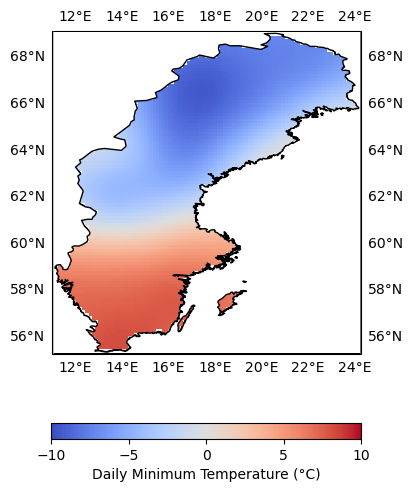

In [158]:
plot_map(da[-1,:], 'Daily Maximum Temperature (°C)', -10, 10)

In [21]:
np.nanmax(max_cwi)

129.5511826557486

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

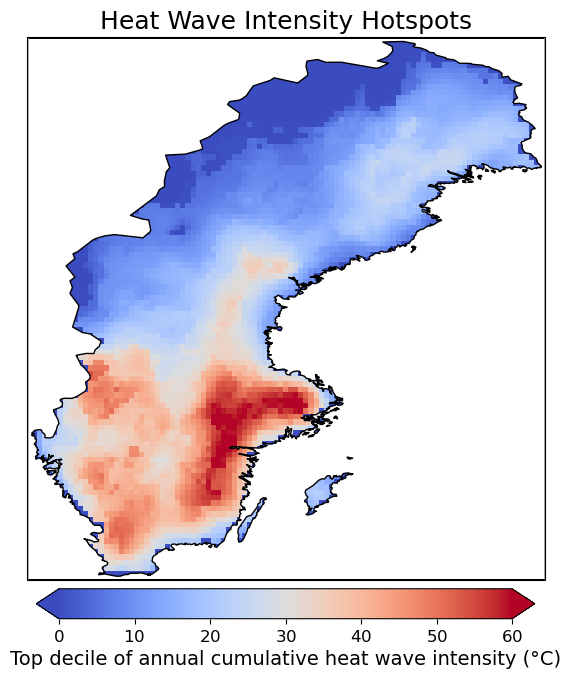

In [18]:
# Plot maximum heatwave intensities
#plot_map(hti_perc_np[2], '90th Percentile Yearly Heat Wave Intensity', 0, 40, 'imshow')
plot_map(hti_perc_np[2], 'Heat Wave Intensity Hotspots', 'Top decile of annual cumulative heat wave intensity (°C)', 0, 60, 10, 'imshow', 'normal','no','no')

In [35]:
# Compute Heatwave and Coldwave Indices
import numpy as np
import xarray as xr

# Load the Tmax and Tmin xarray DataArrays

import pandas as pd
df_stations=pd.read_excel('maxtemp_stations.xlsx')
lat_grid = np.linspace(df_stations['latitude'].min(), df_stations['latitude'].max()+0.5, 100) # corrected
lon_grid = np.linspace(df_stations['longitude'].min(), df_stations['longitude'].max(), 100)
Tmax = xr.open_dataset('max_temp.nc').to_array()

Tmax['lat']=lat_grid
Tmax['lon']=lon_grid

In [33]:
# Compute the Heat Wave Index According to SMHI's definition
#In Sweden, SMHI defines a heat wave as "a continuous period when the highest temperature of the day
#exceeds 25°C for at least five consecutive days”.
HWidx=np.zeros((Tmax.shape[1],Tmax.shape[2],Tmax.shape[3]))
for t in range(Tmax.shape[1]):
    print(t)
    for i in range(Tmax.shape[2]):
        #print(i)
        for j in range(Tmax.shape[3]):
            #print(j)
            tmax = Tmax.values[0,t,i,j]
            HWidx[t,i,j] = tmax-25

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087


3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752


5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400


6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050


8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697


10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
1028

11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
1165

12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
1302

14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
1440

15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
1577

16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
1715

18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
1852

19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
1989

21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
2127

22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
2265

23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
2402

25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
2540

26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
2678

27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
2815

29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
2953

30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
3091

32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
3228

33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
3365

34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
3504

36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
3644

In [ ]:
# Save netcdf data (xarray) of Heat wave Index

import xarray as xr

# Create a 1d array for the time axis
times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')

# Create a DataArray from the dataout numpy array, with the time axis as the first dimension
da = xr.DataArray(HWidx, dims=('time', 'lat', 'lon'), coords={'time': times})
da['lat']=lat_grid
da['lon']=lon_grid
# Convert the DataArray to a Dataset
hwds = da.to_dataset(name='heatwave index')
hwds.to_netcdf('heatwave_SMHI.nc')


C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_5540\1832932462.py:68: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x00000292D378E6D0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_5540\1832932462.py:68: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x00000292D378E610> has a label of '_nolegend_' which cannot be automatically added to the legend.
  fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_5540\1832932462.py:68: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x00000292D378EB80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
C:\Users\MarlonVieiraP

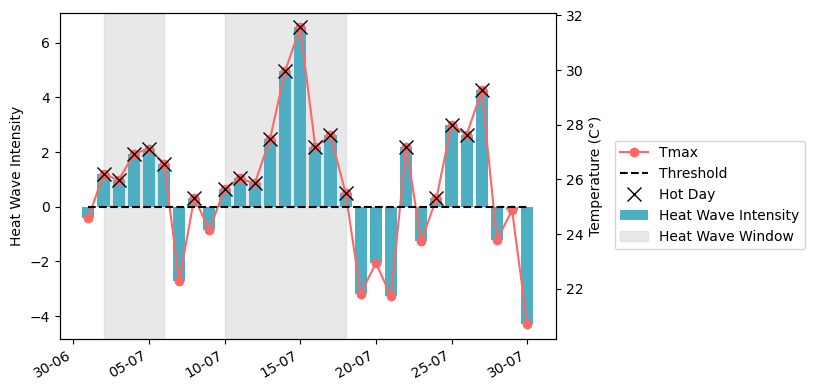

In [38]:
# Plot heatwave definition
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
import pandas as pd


#Get data for June 2021
start_date = "2021-07-01"
end_date = "2021-07-30"
Tmax_mon = Tmax.sel(time=slice(start_date, end_date))

#HWidx_mon = hwds.sel(time=slice(start_date, end_date))
#CWidx_mon = cwds.sel(time=slice(start_date, end_date))

#Get data for one point (i, j) near Stockholm
i=28
j=53
tmax_point = Tmax_mon.values[0, :, i, j]
#HWidx_point = HWidx_mon['heatwave index'].values[:, i, j]
HWidx_point = np.zeros(len(tmax_point))
for i in range(len(tmax_point)):
    #if tmax_point[i]>=25:
    HWidx_point[i]= tmax_point[i]-25
    #else:
        #HWidx_point[i]= 0
time=Tmax_mon.time.values

#Convert the time data to pandas datetime
dates = [pd.to_datetime(d) for d in time]

fig,ax2=plt.subplots()
# Plot heat wave window
hot_days,  hw_idxs_starts, hw_idxs_dur = find_heatwaves(time, tmax_point)
for hw_idxs_start, hw_idxs_dur in zip(hw_idxs_starts[0], hw_idxs_dur):
    ax2.axvspan(dates[hw_idxs_start], dates[hw_idxs_start+int(hw_idxs_dur)-1], color='lightgray', alpha=0.5, label='Heat Wave Window')        
#Plot heat wave intensity
#ax2.plot(dates, HWidx_point, color="black", label="Heat Wave Intensity")
ax2.bar(dates, HWidx_point, color="#4fafc2", label="Heat Wave Intensity", zorder=2)

#Plot the temperature data
ax=ax2.twinx()
ax.plot(dates, tmax_point, marker = 'o', color="#ff6666", label="Tmax", zorder=1)
line25 = [25 for x in dates]
ax.plot(dates, line25, linestyle = '--', color="black", label="Threshold", zorder=1)

# Mark hot days with an X
hd_idxs=np.argwhere(tmax_point>=25) # indexes for hot days
ax.plot(np.array(dates)[hd_idxs], tmax_point[hd_idxs], markersize=10, marker='x', label='Hot Day', color='black', linestyle = 'None')
    
ax.set_xlabel('Date (2021)')
ax.set_ylabel('Temperature (C°)')
ax2.set_ylabel('Heat Wave Intensity')

#Format the x-axis with dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate()

#Add a legend outside the figure to the right
lines = ax.lines + ax2.containers + ax2.patches
labels = [l.get_label() for l in lines]
del lines[4]
del labels[4]
#del lines[-1]
#del labels[-1]
fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

plt.show()

In [37]:
# Calculate heat wave intensities, hot days, durations and frequencies
from scipy.signal import find_peaks
def find_heatwaves(time, tmax_point):
    # Find hot days
    hd_idxs=np.argwhere(tmax_point>=25)
    # determine the indices of the local maxima
    hot_days=np.zeros(len(time))
    hot_days[hd_idxs]=1
    repcountlist=np.zeros(len(time))
    count=1
    for i in range(len(hot_days) - 1):
        # Check if the current and next days are hot
        if hot_days[i] == 1 and hot_days[i+1] == 1:
            count= count+1
        else:
            count= 1
        repcountlist[i]= count
    # check if heatwave occurred:
    hw_idxs=np.where(repcountlist==5) # exact time when heatwave is defined
    #nhwaves=len(hw_idxs)
    # Start of heatwaves
    hw_idxs_starts=[hw_idx-3 for hw_idx in hw_idxs]
    # Duration of heatwaves (peaks of repcountlist above or equal to 3 days)
    peaks_indices = find_peaks(repcountlist)[0] # end of wave
    peaks = repcountlist[peaks_indices]
    threshold = 5
    hw_dur = [value for value in peaks if value >= threshold] # durations above threshold
    #print(len(hw_idxs_starts[0]), len(hw_dur))
    return hot_days,  hw_idxs_starts, hw_dur

In [208]:
# Function to expand yearly quantiles to all period
#import numpy as np
def concat_years(qpoint_year):
    # Create an empty list to store the expanded arrays
    all_years = []
    qpoint_leapyear=qpoint_year
    qpoint_year=np.delete(qpoint_year, 59) # remove leap day (60th of the year) from non-leap years
    # Loop through all years from 1922 to 2021
    for year in range(1922, 2022):
        # Check if the current year is a leap year
        leap = False
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            leap = True
        if leap:
            all_years.extend(qpoint_leapyear)
        else:
            all_years.extend(qpoint_year)
    return np.array(all_years)

In [ ]:
# Count number of heat waves for every timestep at every grid point
nyears=100
# Compute the number of Hot/Cold days and Heat/Coldwaves
Hdays=np.zeros((Tmin.shape[1],Tmin.shape[2],Tmin.shape[3])) 
Hdays_starts=np.zeros((Tmin.shape[1],Tmin.shape[2],Tmin.shape[3])) 
Hdays_dur=np.zeros((Tmin.shape[1],Tmin.shape[2],Tmin.shape[3])) 
times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')
#for t in range(Tmin.shape[1]):
    #print(t)
for i in range(Tmin.shape[2]):
    print(i)
    for j in range(Tmin.shape[3]):
        #print(j)
        tmax_point = Tmax.values[0, :, i, j]
        hot_days,  hw_idxs_starts, hw_dur = find_heatwaves(times, tmax_point)
        Hdays[:,i,j] = hot_days
        Hdays_starts[hw_idxs_starts, i, j] = 1
        Hdays_dur[hw_idxs_starts, i, j] = hw_dur


In [ ]:
# Save data into netCDF 
#counts_ds.close() # for permission errors
import xarray as xr
lon=lon_grid
lat=lat_grid
# Convert arrays to xarray DataArray objects
Hdays = xr.DataArray(Hdays, dims=('time', 'latitude', 'longitude'), coords={'time': times, 'latitude': lat, 'longitude': lon})
Hw_starts = xr.DataArray(Hdays_starts, dims=('time', 'latitude', 'longitude'), coords={'time': times, 'latitude': lat, 'longitude': lon})
Hw_dur = xr.DataArray(Hdays_dur, dims=('time', 'latitude', 'longitude'), coords={'time': times, 'latitude': lat, 'longitude': lon})

# Combine arrays into a single Dataset
ds = xr.Dataset({'Hdays': Hdays, 'Hw_starts': Hw_starts, 'Hw_dur': Hw_dur})

# Save Dataset to a netCDF file
ds.to_netcdf('wavecounts_SMHI.nc')




In [101]:
# Plot number of hot/cold days and heat/cold waves
#count_cd = np.nansum(counts_ds.Cdays.values, axis=0) # number of cold days
#count_hd = np.nansum(counts_ds.Hdays.values, axis=0) # number of cold days
count_hw = np.nansum(counts_ds.Hw_starts.values, axis=0) # number of heatwaves
#count_cw = np.nansum(counts_ds.Cw_starts.values, axis=0) # number of coldwaves

In [3]:
import xarray as xr
HWidx = xr.open_dataset('heatwave_SMHI.nc')#.to_array() # Daily intensitites (not total!)
#CWidx = xr.open_dataset('coldwave.nc')#.to_array() # Daily intensities

In [ ]:
# Count total heatwave intensities
# Loop through all heat waves and sum daily intensities over duration 
HWint=np.zeros((36525, 100, 100))
#counts_ds.Hw_starts.values
timestep=0
all_starts=np.where(counts_ds.Hw_starts.values[:,:,:]==1) # All coordinates when heatwaves happened
for t, i, j in zip(all_starts[0],all_starts[1],all_starts[2]) : # all time and point coordinates
    if t>timestep:
        timestep=t
        print(timestep)
    dur=counts_ds.Hw_dur.values[t,i,j] # duration of heatwave
    total_hw_intensity=0
    for day in range(int(dur)):
        total_hw_intensity=total_hw_intensity+HWidx['heatwave index'].values[t+day,i,j]
    HWint[t,i,j]=total_hw_intensity
   

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

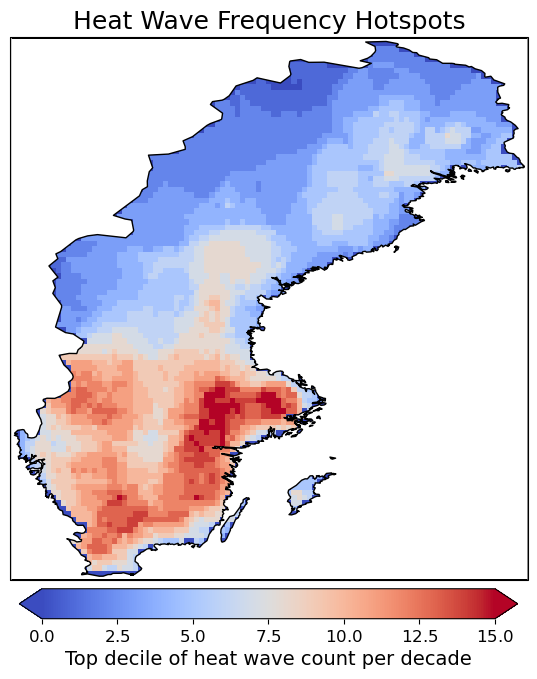

In [19]:
freq_perc_hw=calc_percentiles(counts_ds_decade.Hw_starts.values)
plot_map(freq_perc_hw[2], 'Heat Wave Frequency Hotspots', 'Top decile of heat wave count per decade', 0, 15, 1, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

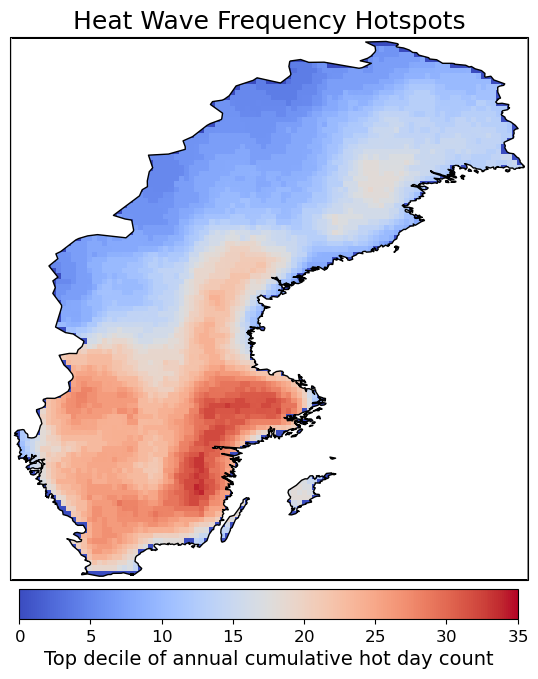

In [193]:
freq_perc_hw=calc_percentiles(counts_ds_yearly.Hdays.values)
plot_map(freq_perc_hw[2], 'Heat Wave Frequency Hotspots', 'Top decile of annual cumulative hot day count', 0, 35, 30, 'imshow', 'normal','no','no')

In [29]:
np.nansum(count_cd)/np.nansum(count_cw)

9.396510075294612

In [28]:
import pandas as pd
import numpy as np
df_stations=pd.read_excel('mintemp_stations.xlsx')
lat_grid = np.linspace(df_stations['latitude'].min(), df_stations['latitude'].max()+0.5, 100) # corrected
lon_grid = np.linspace(df_stations['longitude'].min(), df_stations['longitude'].max(), 100)


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

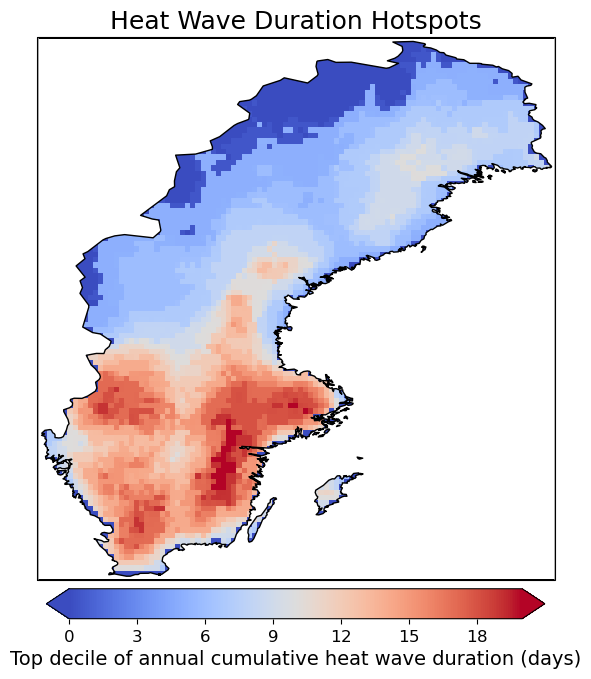

In [22]:
# Plot longest durations
plot_data=dur_perc_hw[2]
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
ub=20
lb=0
#plot_map(plot_data, '90th Percentile Yearly Heat Wave Duration (days)', lb, ub, 'imshow')
plot_map(plot_data, 'Heat Wave Duration Hotspots', 'Top decile of annual cumulative heat wave duration (days)', lb, ub, (lb+ub)/2, 'imshow', 'normal','no','no')

In [21]:
# Calculate average and total heat wave duration at each point
counts_ds_yearly =counts_ds.resample(time='1Y').sum('time')
counts_ds_decade =counts_ds.resample(time='10Y').sum('time')
def calc_percentiles(data):
    return np.nanpercentile(data, [10, 50, 90], axis=0)

dur_perc_hw=calc_percentiles(counts_ds_yearly.Hw_dur.values)

In [234]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Get the dimensions of the dataset
dims = counts_ds_yearly_sum.dims

# Create arrays to hold the slope and r-value for each point
slope = np.zeros((dims['longitude'], dims['latitude']))
rvalue = np.zeros((dims['longitude'], dims['latitude']))

# Loop over each point in the dataset and calculate the slope and p-value of the linear regression
for i in range(dims['longitude']):
    for j in range(dims['latitude']):
        x = counts_ds_yearly_sum.Hw_starts[:, i, j].values
        y = np.arange(dims['time'])
        mask = ~np.isnan(x)
        if mask.sum() > 1:
            slope[i, j], _, rvalue[i, j], _, _ = linregress(y[mask], x[mask])


In [26]:
import xarray as xr
#HWidx_yearly_max = HWidx.resample(time='1Y').max('time')
HWint=xr.open_dataset('tot_hw_intensity_SMHI.nc')
#HWint_yearly_sum = HWint.resample(time='1Y').sum('time')

In [3]:
#CWidx_yearly_max = CWidx.resample(time='1Y').max('time')
CWint=xr.open_dataset('tot_cw_intensity.nc')
#CWint_yearly_sum = CWint.resample(time='1Y').sum('time')

In [39]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
def test_normality(d):
    x = d.ravel()
    x = x[~np.isnan(x)]
    # normality test
    stat, p = shapiro(x)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret results
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

def calculate_trends(data_array, alpha=0.05):
    timesteps, n_lat, n_lon = data_array.shape

    x = np.arange(timesteps)
    rate_of_change = np.empty((n_lat, n_lon))

    for i in range(n_lat):
        for j in range(n_lon):
            y = data_array[:, i, j]
            mask = ~np.isnan(y)
            if mask.sum() > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
                if p_value <= alpha:
                    rate_of_change[i, j] = slope
                else:
                    rate_of_change[i, j] = np.nan
            else:
                rate_of_change[i, j] = np.nan

    return rate_of_change



C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

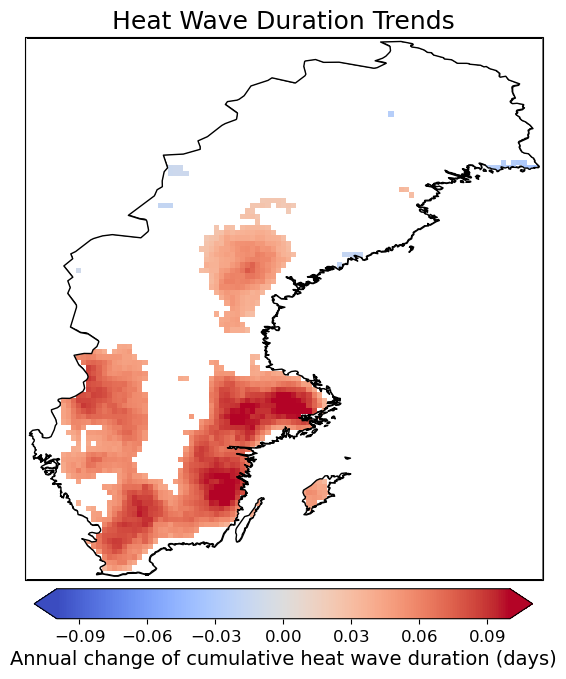

In [23]:
hw_dur_rate=calculate_trends(counts_ds_yearly.Hw_dur.values)
#(interp_temps, title, label, lower_bound, upper_bound, vcenter, option, cmap_type, save, filename):
plot_map(hw_dur_rate, 'Heat Wave Duration Trends', 'Annual change of cumulative heat wave duration (days)', -0.1, 0.1, 0, 'imshow','coolwarm', 'no', 'no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

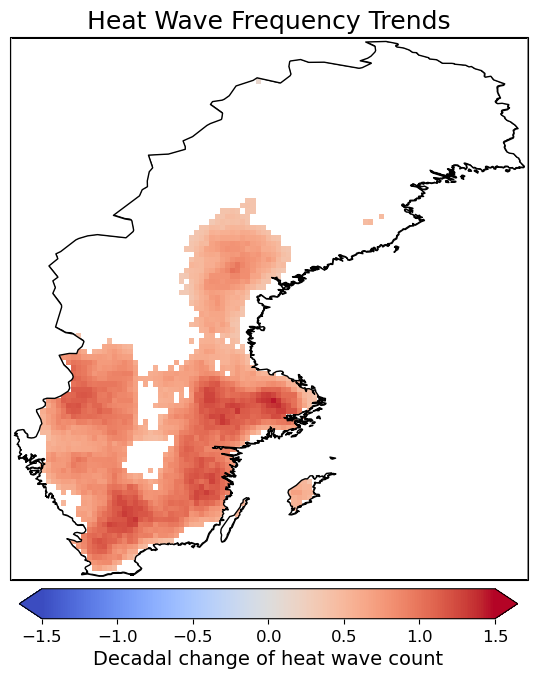

In [24]:
#hw_freq_rate=calculate_trends(counts_ds_yearly.Hdays.values)
hw_freq_rate=calculate_trends(counts_ds_decade.Hw_starts.values)
plot_map(hw_freq_rate, 'Heat Wave Frequency Trends', 'Decadal change of heat wave count', -1.5, 1.5, 0, 'imshow','coolwarm', 'no', 'no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

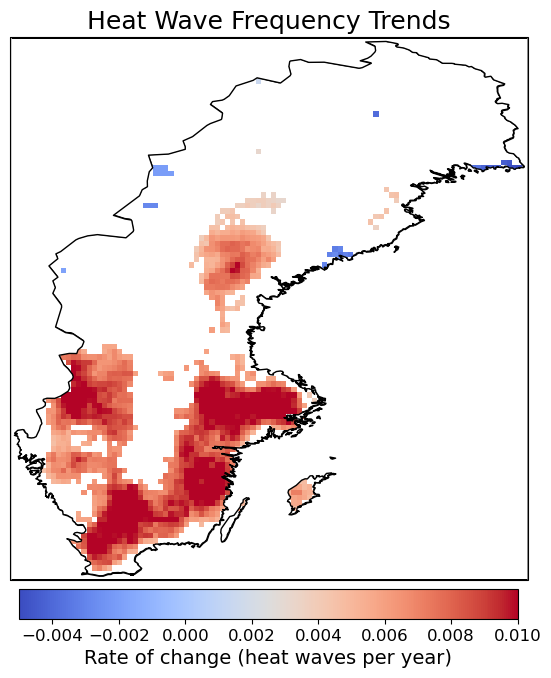

In [141]:
hw_freq_rate=calculate_trends(counts_ds_yearly.Hw_starts.values)
plot_map(hw_freq_rate, 'Heat Wave Frequency Trends', 'Rate of change (heat waves per year)', -0.005, 0.01, 0, 'imshow','coolwarm', 'no', 'no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

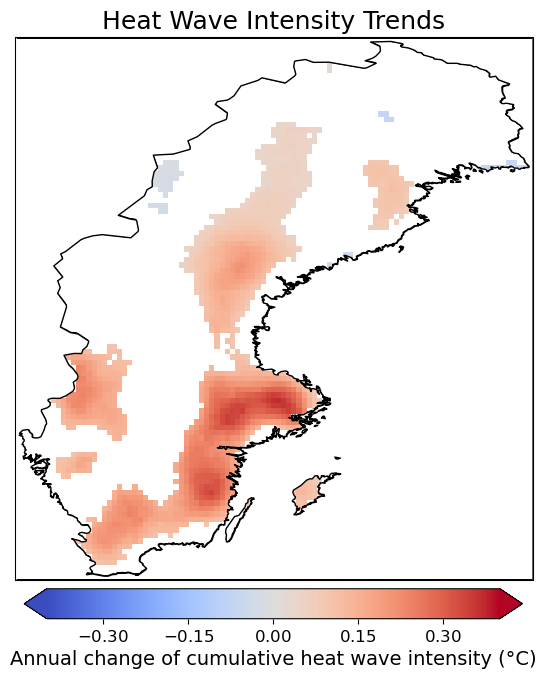

In [25]:
hw_intensity_rate=calculate_trends(HWint_yearly['heatwave index'].values)
plot_map(hw_intensity_rate, 'Heat Wave Intensity Trends', 'Annual change of cumulative heat wave intensity (°C)', -0.4, 0.4, 0, 'imshow','coolwarm', 'no', 'no')
#plot_map(hw_intensity_corr, 'Heat Wave Intensity Trends (R-value)', -.5, .5, 'imshow')

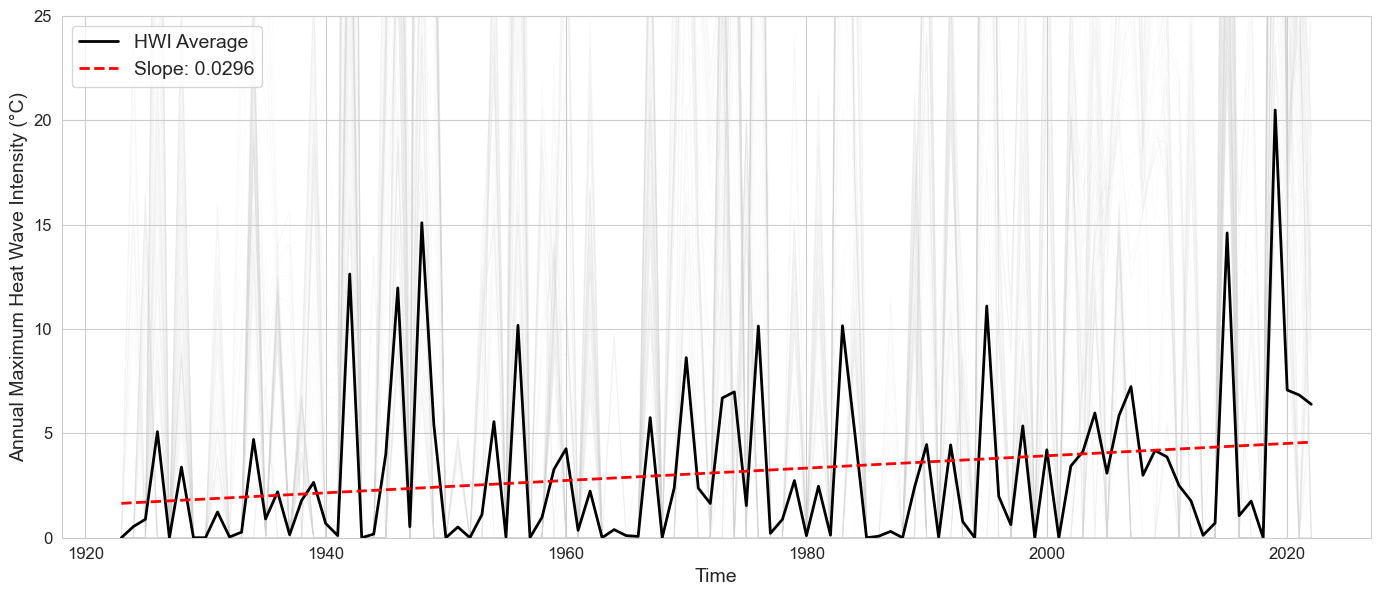

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import xarray as xr
# load the xarray dataset with SPEI values
#hwi_ds = xr.open_dataset(('heatwave_SMHI.nc'))
#hwi_ds = hwi_ds.resample(time='1Y').max()
hwi_ds = xr.open_dataset(('tot_hw_intensity_SMHI.nc'))
hwi_ds = hwi_ds.resample(time='1Y').sum()
# convert dataset to dataframe
hwi_df = hwi_ds.to_dataframe().reset_index()


# plot the data
plt.figure(figsize=(14,6))
sns.set_style('whitegrid')
for lat, lon in zip(hwi_df['lat'].unique(), hwi_df['lon'].unique()):
    hwi_df_subset = hwi_df[(hwi_df['lat'] == lat) & (hwi_df['lon'] == lon)]
    x = hwi_df_subset['time']
    y = hwi_df_subset['heatwave index']
    plt.plot(x, y, color='lightgray', alpha=0.1, linewidth=0.5)   
avg_hwi_df = hwi_df.groupby('time').mean().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(avg_hwi_df.index.values, avg_hwi_df['heatwave index'])
trend_line = slope * avg_hwi_df.index.values + intercept
plt.plot(avg_hwi_df['time'], avg_hwi_df['heatwave index'], color='black', linewidth=2, label='HWI Average')
plt.plot(avg_hwi_df['time'], trend_line, color='red', linestyle='--', linewidth=2, label='Slope: '+str(round(slope,4)))



plt.xlabel('Time', fontsize=14)
plt.ylabel('Annual Maximum Heat Wave Intensity (°C)', fontsize=14)
#plt.title('SPEI12 Timeseries', fontsize=14)
# Set the font size for tick labels
plt.tick_params(axis='both', labelsize=12)
#plt.legend(loc='upper center', ncol=10)
plt.legend(fontsize=14, loc='upper left')
plt.tight_layout()
plt.ylim([0, 25])
plt.savefig('HCWI.svg')
plt.show()

In [88]:
import seaborn as sns
from scipy.stats import pearsonr
def plot_reg(df, colx, coly, lbx, lby):
    df=df.dropna()
    # Calculate correlation coefficient
    corr, _ = pearsonr(df[colx], df[coly])
    # Create scatter plot with regression line and correlation coefficient
    g=sns.jointplot(x=colx, y=coly, data=df, kind='reg',  line_kws={"color":"red"})
    # Add text box with correlation coefficient
    g.ax_joint.text(0.1, 0.9, f"R = {corr:.2f}", fontsize=12,
                transform=g.ax_joint.transAxes,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    # Set custom x and y axis labels
    g.set_axis_labels(lbx, lby)
    # Display the plot
    plt.show()    